In [2]:
# import pacakges

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D

from sklearn.model_selection import train_test_split
import pandas as pd 

In [3]:
df = pd.read_csv("../preprocessing/output.csv")
X = df['review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Tokenize the words 
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

# Add 1 for the zero's 
vocab_length = len(word_tokenizer.word_index) + 1

# Add padding to the sentences if need be 
maxlen = 500

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Load GloVe word embeddings and create an Embeddings Dictionary
glove_path = "/Users/dylan/Documents/school/big_data/scientist_engineer_assignments/assignment_2/dask-machine-learning/miscelanious/glove.6B/glove.6B.100d.txt"

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open(glove_path, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [4]:
# Convolutional Network architecture

from keras.layers import Conv1D

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

/Users/dylan/Documents/school/big_data/scientist_engineer_assignments/assignment_2/dask-machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [5]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       159,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,200 (621.88 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 159,200 (621.88 KB)

None


In [6]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - acc: 0.5188 - loss: 0.6838 - val_acc: 0.9000 - val_loss: 0.3576
Epoch 2/6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - acc: 0.9325 - loss: 0.2275 - val_acc: 0.9000 - val_loss: 0.4746
Epoch 3/6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 0.9325 - loss: 0.2425 - val_acc: 0.9000 - val_loss: 0.5482
Epoch 4/6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - acc: 0.9299 - loss: 0.2668 - val_acc: 0.9000 - val_loss: 0.5717
Epoch 5/6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - acc: 0.9272 - loss: 0.2727 - val_acc: 0.9000 - val_loss: 0.5650
Epoch 6/6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - acc: 0.9351 - loss: 0.2219 - val_acc: 0.9000 - val_loss: 0.5368


In [7]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.9600 - loss: 0.2405


In [8]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3500767648220062
Test Accuracy: 0.9399999976158142


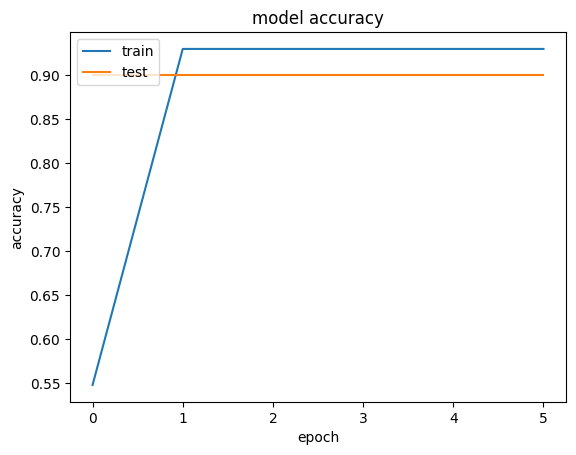

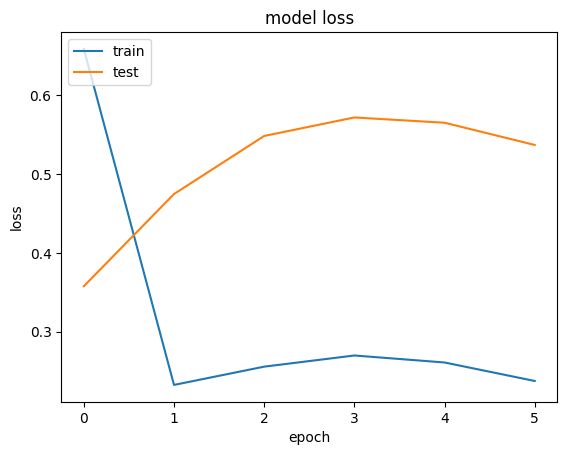

In [9]:
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()